In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
np.random.seed(42)
torch.manual_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Problem settings

In [2]:
def analytical_solution(t, k, mu, m):
    omega = torch.sqrt(4*m*k-mu**2)/(2*m)
    decay = torch.exp(-mu/(2*m)*t)
    sin = torch.cos(omega*t) + (mu/(2*m))/omega * torch.sin(omega*t)
    u_analytical = decay * sin
    return u_analytical

Note something about the problem settings here

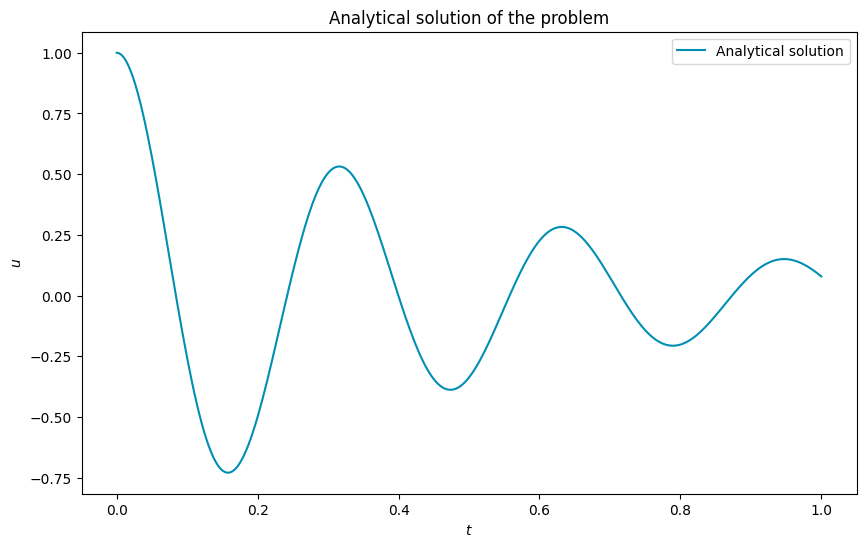

In [3]:
k = torch.tensor(400)
mu = torch.tensor(4)
m = torch.tensor(1)
t_max = torch.tensor(1)
light_cyan = "#008fb3"
light_orange = "#ff8000"
# ground truth for evaluation
t_test = torch.linspace(0, 1, 300).double().view(-1,1)
u_test = analytical_solution(t_test, k, mu, m)
t_test_cuda = t_test.to(device)
u_test_cuda = u_test.to(device)
# visualize grouth truth
plt.figure(figsize=(10,6))
plt.plot(t_test, u_test, label="Analytical solution", color=light_cyan)
plt.xlabel("$t$")
plt.ylabel("$u$")
plt.title("Analytical solution of the problem")
plt.legend()
plt.show()

# Model training

## Example sampling in training loop

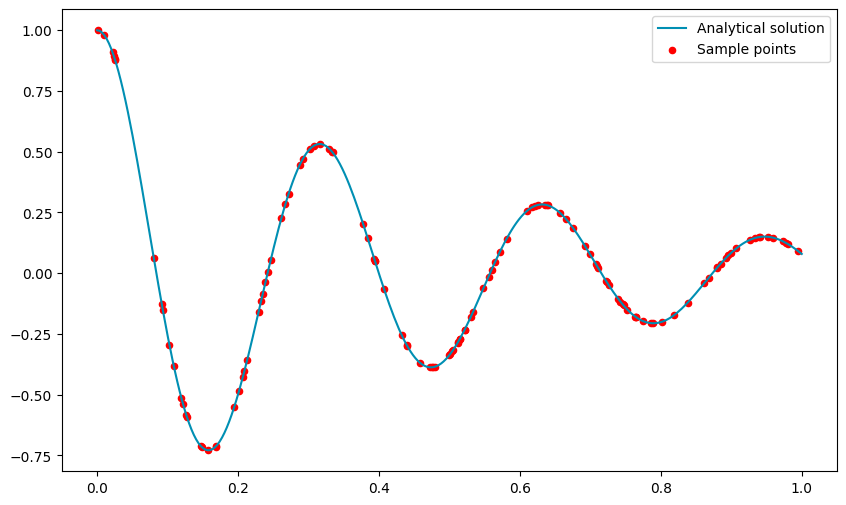

In [4]:
n_samples = 125

g = torch.Generator(device=device)
t_pde = torch.rand(n_samples, device=device, generator=g).view(-1,1).double()
t_pde = t_pde * t_max # scale with [0,t_max]
t_pde.requires_grad = True
t_pde_cpu = t_pde.cpu()
t_pde_numpy = t_pde_cpu.detach().numpy()
u_pde = analytical_solution(t_pde_numpy, k, mu, m)
t_boundary = torch.tensor(0.).view(-1,1).requires_grad_(True)
t_boundary = t_boundary.double()

# visualize random samples
plt.figure(figsize=(10,6))
plt.plot(t_test, u_test, color=light_cyan,label="Analytical solution")
plt.scatter(t_pde_numpy, u_pde, color="red", s=20, label="Sample points")
plt.legend()
plt.show()

## Model setup

In [5]:
class FCN(nn.Module):
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super().__init__()
        activation = nn.Tanh
        #self.input_layer = nn.Sequential(*[nn.Linear(N_INPUT, N_HIDDEN), activation()])
        #self.hidden_layers = nn.Sequential(*[nn.Sequential(*[nn.Linear(N_HIDDEN, N_HIDDEN),activation()]) for _ in range(N_LAYERS-1)])
        #self.output_layer = nn.Linear(N_HIDDEN, N_OUTPUT)
        self.input_layer = nn.Sequential(*[
                        nn.Linear(N_INPUT, N_HIDDEN),
                        activation()])
        self.hidden_layers = nn.Sequential(*[
                        nn.Sequential(*[
                            nn.Linear(N_HIDDEN, N_HIDDEN),
                            activation()]) for _ in range(N_LAYERS-1)])
        self.output_layer = nn.Linear(N_HIDDEN, N_OUTPUT)
        self.initialize_weights()
    def forward(self,x):
        x = self.input_layer(x)
        x = self.hidden_layers(x)
        x = self.output_layer(x)
        return x

    def initialize_weights(self):
        # Xavier initialization
        for layer in self.children():
            if isinstance(layer, nn.Linear):
                init.xavier_normal_(layer.weight, gain=np.sqrt(5))
                if layer.bias is not None:
                    init.zeros_(layer.bias)

In [6]:
def compute_MSE(x_predict, x_true):
    error = x_predict - x_true
    E = torch.mean(error**2)
    return E

## Training loops over n_samples

In [9]:
def pinn_model_predict(n_samples):
    pinn = FCN(1, 1,32,3).double().to(device)
    optimizer = torch.optim.Adam(pinn.parameters(), lr=1e-3)
    epochs = 5000
    lambda1, lambda2 = 1e-1, 1e-3

    t_pde_cuda = torch.rand(n_samples, device=device, generator=g).view(-1,1).double().to(device)
    t_pde_cuda = t_pde_cuda * t_max # scale with [0,t_max]
    t_pde_cuda.requires_grad = True
    # for visualization
    t_pde_cpu = t_pde_cuda.cpu()
    t_pde_numpy = t_pde_cpu.detach().numpy()
    u_pde_numpy_exact = analytical_solution(t_pde_numpy, k, mu, m)

    t_boundary = torch.tensor(0.).view(-1,1).requires_grad_(True)
    t_boundary = t_boundary.double().to(device)

    #t_pde_to_tensor = torch.linspace(0,1,n_samples).view(-1,1)
    #t_pde_to_tensor = t_pde_to_tensor.to(device)
    #t_pde_to_tensor = t_pde_to_tensor.double()
    #t_pde_to_tensor.requires_grad = True
    #n_test_sample = 100
    #t_test = torch.linspace(0,1,n_test_sample).view(-1,1).to(device)
    for i in range(epochs):
        #pinn.train()
        optimizer.zero_grad()
        """
        # compute data loss
        u_pred = pinn(t_data_to_tensor)
        data_residual = u_pred-u_data_to_tensor
        data_loss = torch.mean(data_residual**2) # (1/N) * torch.sum(data_residual**2) # = mean
        """
        # compute boundary loss
        u = pinn(t_boundary)
        loss1 = (torch.squeeze(u) - 1)**2
        dudt = torch.autograd.grad(u, t_boundary, torch.ones_like(u), create_graph=True)[0]
        loss2 = (torch.squeeze(dudt) - 0)**2
        # compute pde loss
        u_pred = pinn(t_pde_cuda)
        du_dt = torch.autograd.grad(u_pred, t_pde_cuda, torch.ones_like(u_pred).to(device),create_graph=True)[0]
        d2u_dt2 = torch.autograd.grad(du_dt, t_pde_cuda, torch.ones_like(du_dt).to(device),create_graph=True)[0]
        loss3 = torch.mean((m*d2u_dt2+mu*du_dt+k*u_pred)**2) #(1/M) * torch.sum((m*d2u_dt2+mu*du_dt+k*u_pred)**2)
        total_loss = loss1 + lambda1*loss2 + lambda2*loss3
        total_loss.backward()
        #print(f"Epoch {i}, loss {total_loss}")
        optimizer.step()

    # visualize random samples

    u_test_pred_cuda = pinn(t_test_cuda)
    u_test_pred_numpy =  u_test_pred_cuda.cpu().detach().numpy()

    plt.figure(figsize=(10,6))
    plt.plot(t_test, u_test, color='blue',label="Analytical solution")
    plt.plot(t_test, u_test_pred_numpy, color=light_orange,label="PINNs solution")
    plt.title(f"Number of samples {n_samples}: PINNs vs Analytical Solution")
    plt.xlabel("$u$")
    plt.ylabel("$t$")
    plt.scatter(t_pde_numpy, u_pde_numpy_exact, color="red", s=20, label="Sample points")
    plt.legend()
    plt.show()

    return u_test_pred_cuda

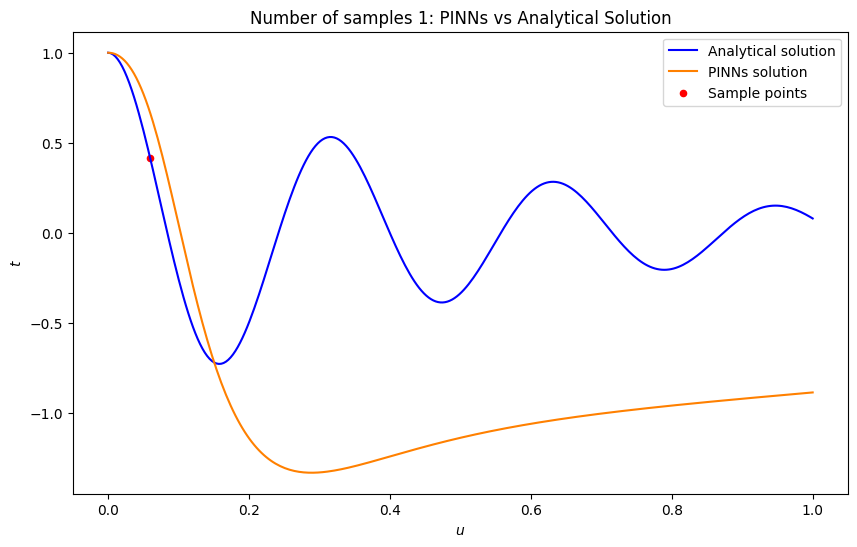

For 1 samples, the loss is 1.096471653028078


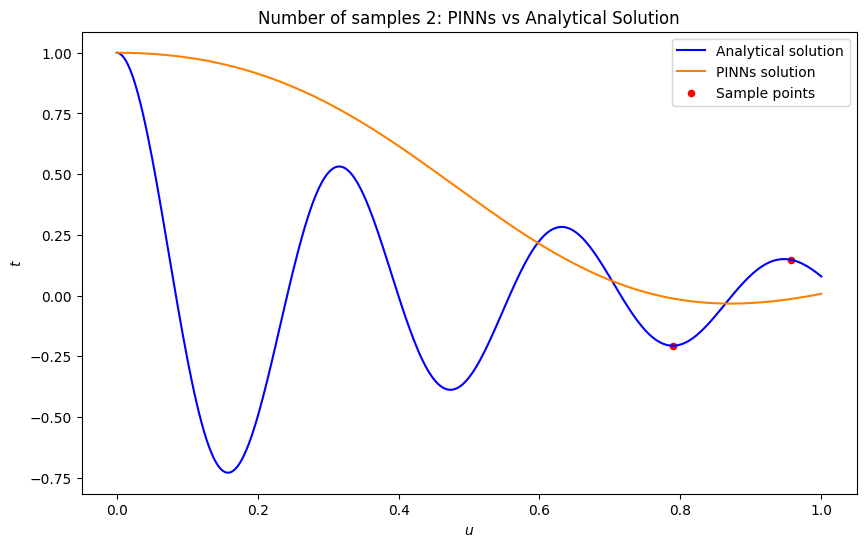

For 2 samples, the loss is 0.4578974619667089


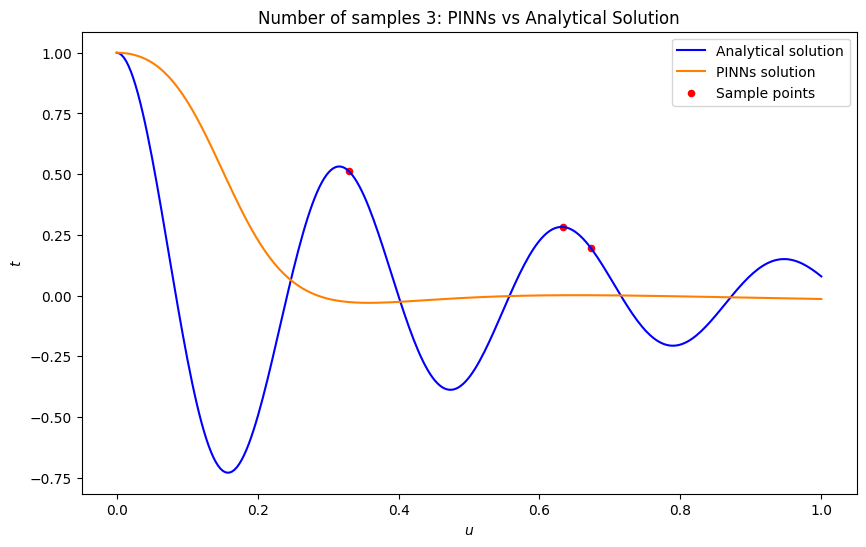

For 3 samples, the loss is 0.21167223528851267


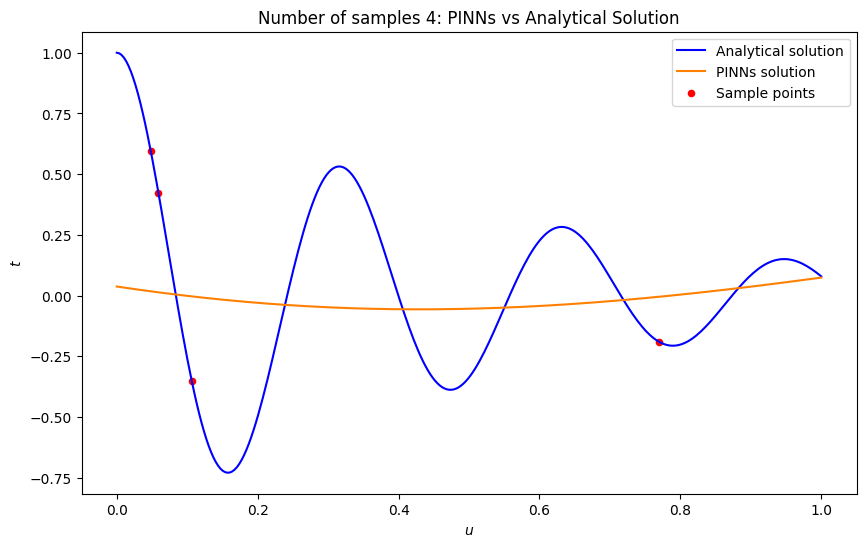

For 4 samples, the loss is 0.12691225679901047


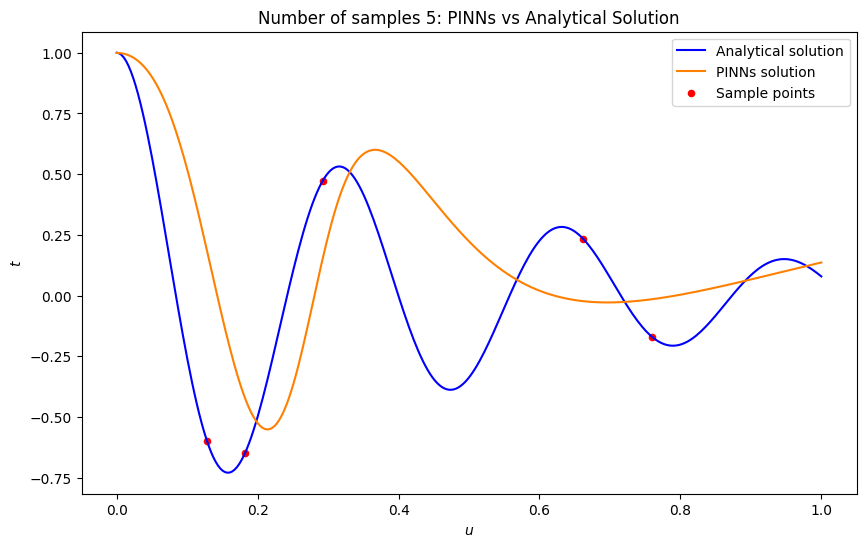

For 5 samples, the loss is 0.14010910557203057


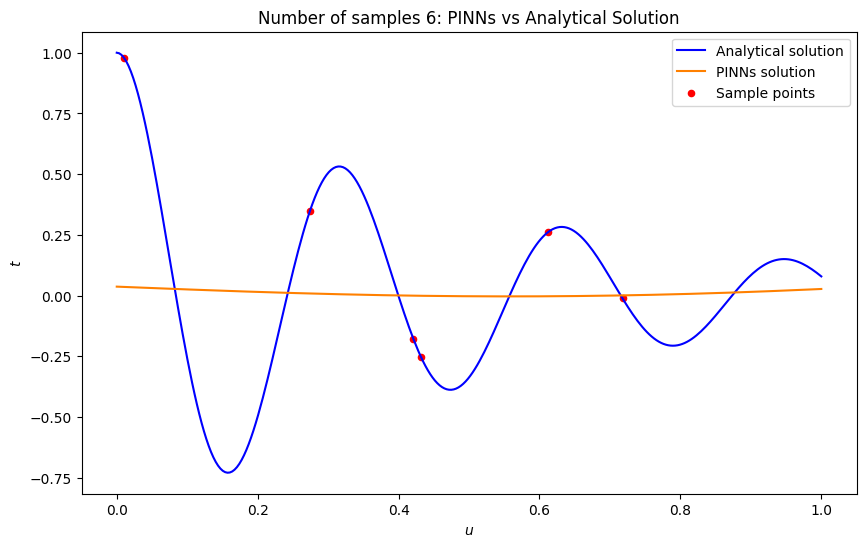

For 6 samples, the loss is 0.12760132909100938


In [ ]:
n_max_sample = 1000
#n_test_sample = 300

E_values = []

for i in range(1, n_max_sample+1):
    n_samples = torch.tensor(i)
    u_pred = pinn_model_predict(n_samples=n_samples)
    E = compute_MSE(u_pred,u_test_cuda)
    E_values.append(E)
    print(f"For {i} samples, the loss is {E}")

In [ ]:
E_numerical_values = [tensor.item() for tensor in E_values]
nSamples_values = np.arange(1, len(E_values)+1).reshape(-1,1)

plt.figure(figsize=(10,6))
plt.plot(nSamples_values, E_numerical_values, marker='o')
plt.xlabel('Samples')
plt.ylabel('Values')
plt.title('Errors of decreasing number of samples')
plt.show()